In [1]:
from qiskit import *
from qiskit_aer import Aer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , accuracy_score 
from qiskit import QuantumCircuit , transpile
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from qiskit_ibm_runtime import QiskitRuntimeService , Session , Sampler 

In [2]:
#importing the dataset
#used MNIST digits dataset (data set contains digits from 0 to 9)

mnist = fetch_openml('mnist_784', version=1)
X,y = mnist.data, mnist.target.astype(int)


subset_size = 150 
X, _, y, _ = train_test_split(X, y, train_size=subset_size, random_state=42, stratify=y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size =100 ,  random_state=42, stratify=y) 


In [3]:
#applying normalization using PCA and used minmaxscaler

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import numpy as np


pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)
X_test_scaled = scaler.transform(X_test_pca)

print("Training data after PCA normalization : ", X_train_scaled.shape)
print("Testing data after PCA normalization : ", X_test_scaled.shape)


Training data after PCA normalization :  (100, 10)
Testing data after PCA normalization :  (50, 10)


In [4]:
#feature map
#feature map encodes a classical data point into a quantum state using a quantum circuit
def feature_map(circuit , data):
    n = len(data)
    for i  in range(len(data)):
        circuit.h(i)
    for i , value in enumerate(data):
        value  = float(value)
        circuit.rx(2 *np.pi * value,i)
        circuit.ry(2 *np.pi * value,i)
    return circuit
data_point = X_train_pca[0]

c = QuantumCircuit(len(data_point))
c = feature_map(c, data_point)

c.draw()

┌───┐ ┌───────────┐  ┌───────────┐ 
q_0: ┤ H ├─┤ Rx(13070) ├──┤ Ry(13070) ├─
     ├───┤┌┴───────────┴┐┌┴───────────┴┐
q_1: ┤ H ├┤ Rx(-1270.4) ├┤ Ry(-1270.4) ├
     ├───┤├─────────────┤├─────────────┤
q_2: ┤ H ├┤ Rx(-2293.9) ├┤ Ry(-2293.9) ├
     ├───┤└┬────────────┤└┬────────────┤
q_3: ┤ H ├─┤ Rx(444.04) ├─┤ Ry(444.04) ├
     ├───┤┌┴────────────┤┌┴────────────┤
q_4: ┤ H ├┤ Rx(-3732.6) ├┤ Ry(-3732.6) ├
     ├───┤├─────────────┤├─────────────┤
q_5: ┤ H ├┤ Rx(-2077.4) ├┤ Ry(-2077.4) ├
     ├───┤└┬───────────┬┘└┬───────────┬┘
q_6: ┤ H ├─┤ Rx(-1953) ├──┤ Ry(-1953) ├─
     ├───┤┌┴───────────┴┐┌┴───────────┴┐
q_7: ┤ H ├┤ Rx(-2840.4) ├┤ Ry(-2840.4) ├
     ├───┤└┬────────────┤└┬────────────┤
q_8: ┤ H ├─┤ Rx(1116.1) ├─┤ Ry(1116.1) ├
     ├───┤┌┴────────────┤┌┴────────────┤
q_9: ┤ H ├┤ Rx(-3504.3) ├┤ Ry(-3504.3) ├
     └───┘└─────────────┘└─────────────┘

In [5]:
#statevector visualization of the encoded quantum data 

backend = Aer.get_backend('statevector_simulator')

quantum_data = []
for sample in X_train_scaled:
    circuit = QuantumCircuit(len(sample))

    feature_map(circuit , sample)

    transpiled_circuit = transpile(circuit , backend)

    job = backend.run(transpiled_circuit)

    result = job.result()

    statevector = result.get_statevector()

    quantum_data.append(statevector)

print(quantum_data)

[Statevector([-3.38440135e-06+3.85985190e-07j,
             -3.38440135e-06+3.85985190e-07j,
              8.99389909e-06-1.02573882e-06j, ...,
              8.07141210e-02-9.20530755e-03j,
             -2.14494259e-01+2.44627036e-02j,
             -2.14494259e-01+2.44627036e-02j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), Statevector([ 1.28561512e-03+0.00219892j, -6.84172735e-03-0.01170209j,
             -6.55441987e-04-0.00112107j, ..., -8.34150645e-04-0.00142673j,
             -7.99121814e-05-0.00013668j,  4.25272967e-04+0.00072739j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), Statevector([-0.00048476-0.00059159j, -0.00056165-0.00068543j,
              0.00030509+0.00037232j, ..., -0.07326598-0.08941214j,
              0.03979806+0.04856865j,  0.04611115+0.056273j  ],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), Statevector([-2.81779533e-06+1.21643068e-05j,
             -1.09628518e-06+4.73261811e-06j,
              3.70991037e-06-1.60155308e-05j, ...,
          

In [6]:
#quantum kernel to compute the inner product SWAP test is used to design this kernel

from qiskit_aer import Aer , AerSimulator
def quantum_kernel(x1,x2):
    n = len(x1)
    circuit1 = QuantumCircuit(n)
    circuit2 = QuantumCircuit(n)

    circuit1 = feature_map(circuit1,x1)
    circuit2 = feature_map(circuit2,x2)

    circuit = QuantumCircuit(2*n + 1,1)

    circuit.append(circuit1, range(n))
    circuit.append(circuit2, range(n, 2*n))

    circuit.h(2*n)
    for i in range(n):
        circuit.cswap(2*n, i, n+i)
    circuit.h(2*n)
    
    circuit.measure(2*n,0)

    return circuit

circuits = []
n = len(X_train_scaled)
for i in range(n):
    for j in range(n):
        x1 = X_train_scaled[i]
        x2 = X_train_scaled[j]
        circuit = quantum_kernel(x1,x2)
        circuits.append(circuit)
print(circuits[0])
print(f'circuit depth : {circuits[0].depth()}')

      ┌──────────────┐                                      
 q_0: ┤0             ├─X────────────────────────────────────
      │              │ │                                    
 q_1: ┤1             ├─┼──X─────────────────────────────────
      │              │ │  │                                 
 q_2: ┤2             ├─┼──┼──X──────────────────────────────
      │              │ │  │  │                              
 q_3: ┤3             ├─┼──┼──┼──X───────────────────────────
      │              │ │  │  │  │                           
 q_4: ┤4             ├─┼──┼──┼──┼──X────────────────────────
      │  circuit-367 │ │  │  │  │  │                        
 q_5: ┤5             ├─┼──┼──┼──┼──┼──X─────────────────────
      │              │ │  │  │  │  │  │                     
 q_6: ┤6             ├─┼──┼──┼──┼──┼──┼──X──────────────────
      │              │ │  │  │  │  │  │  │                  
 q_7: ┤7             ├─┼──┼──┼──┼──┼──┼──┼──X───────────────
      │              │ │

In [7]:
#batch processing due to large number of circuits 

batch_size = 10
n = len(X_train_scaled)
circuits =[]
for i in range(n):
    batch_circuits = []
    for j in range(n):
        x1 = X_train_scaled[i]
        x2 = X_train_scaled[j]
        circuit = quantum_kernel(x1,x2)
        batch_circuits.append(circuit)

    if len(batch_circuits) == batch_size or j  == n -1 :
        circuits.extend(batch_circuits)
        batch_circuits=[]

print("number of circuits genearted are : ", len(circuits))

simulator = AerSimulator()

transpiled_circuits = transpile(circuits , simulator)

job = simulator.run(transpiled_circuits , shots = 1024)

result = job.result()

counts_list = result.get_counts()

print("number of counts recieved are : ", len(counts_list))
kernel_values = []

for counts in counts_list:
    zero_prob = counts.get('0',0) / 1024
    kernel_value = (2*zero_prob)-1
    kernel_values.append(kernel_value)

# unique_kernel_values = set(kernel_values)

# print("number of unique kernel values are : ", len(unique_kernel_values))

print(kernel_values)
print("number of kernle values are :", len(kernel_values))

#print(circuits[0])


number of circuits genearted are :  10000
number of counts recieved are :  10000
[1.0, 0.009765625, -0.0078125, 0.0859375, 0.037109375, 0.0234375, -0.01953125, -0.025390625, 0.01953125, -0.056640625, -0.005859375, -0.015625, -0.00390625, -0.041015625, 0.0, -0.03125, 0.03125, 0.021484375, -0.05078125, 0.06640625, -0.0234375, -0.046875, 0.044921875, -0.009765625, 0.013671875, 0.025390625, -0.03515625, -0.015625, -0.025390625, -0.0234375, -0.013671875, 0.04296875, -0.009765625, 0.04296875, 0.0, -0.009765625, -0.03125, -0.056640625, 0.041015625, -0.033203125, -0.072265625, 0.021484375, -0.060546875, -0.052734375, -0.013671875, 0.123046875, 0.013671875, 0.021484375, 0.001953125, -0.041015625, 0.041015625, 0.021484375, -0.064453125, 0.072265625, -0.041015625, -0.01171875, 0.009765625, 0.03125, -0.00390625, -0.013671875, 0.048828125, 0.005859375, 0.0703125, -0.02734375, -0.056640625, 0.048828125, -0.04296875, 0.0, -0.0546875, -0.01953125, -0.03515625, -0.001953125, -0.025390625, 0.001953125, 

In [8]:
# the extracted kernel values are arranged in the form of a matrix called kernel matrix 
#the kernel matrix has to be PSD that means the eigen values of the extracted kernel values must be positive 
#this condition may not always be met so to make the kernel matrix a PSD nearest_psd method is used 
#in nearest_psd method the negative values are clipped down to 0 thus getting a valid kernel matrix 

kernel_matrix = np.array(kernel_values).reshape(n, n)


def nearest_psd(matrix):
    
    
    eigenvalues, eigenvectors = np.linalg.eigh(matrix)
    
   
    clipped_eigenvalues = np.clip(eigenvalues, 0, None)
    
   
    psd_matrix = eigenvectors @ np.diag(clipped_eigenvalues) @ eigenvectors.T
    
   
    psd_matrix[psd_matrix < 0] = 0
    
    return psd_matrix


kernel_matrix_psd = nearest_psd(kernel_matrix)

print("Corrected Kernel Matrix:")
print(kernel_matrix_psd)

Corrected Kernel Matrix:
[[1.00014074 0.         0.00392384 ... 0.         0.         0.00184304]
 [0.         1.00070173 0.         ... 0.00209756 0.00148951 0.07982966]
 [0.00392384 0.         1.02738066 ... 0.07925538 0.05890111 0.03077278]
 ...
 [0.         0.00209756 0.07925538 ... 1.00003037 0.00184944 0.17377688]
 [0.         0.00148951 0.05890111 ... 0.00184944 1.00041319 0.        ]
 [0.00184304 0.07982966 0.03077278 ... 0.17377688 0.         1.00008799]]


In [9]:
#training the classical svm with the  extrcated quantum kernel matix this making it a quantum support vector machine 
#testing it on the testing data 
#calculating the accuracy

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import accuracy_score, classification_report


svm_classifier = SVC(kernel='precomputed')  
svm_classifier.fit(kernel_matrix_psd , y_train)


kernel_test = np.zeros((len(X_test_scaled), len(X_train_scaled)))


for i in range(len(X_test_scaled)):
    for j in range(len(X_train_scaled)):
        circuit = quantum_kernel(X_test_scaled[i], X_train_scaled[j])  
        job = simulator.run(transpile([circuit], simulator))
       
        result = job.result()
        
        counts = result.get_counts()
        zero_prob = counts.get('0', 0) / 1024  
        kernel_value = (2 * zero_prob) - 1
        kernel_test[i, j] = kernel_value  


predictions = svm_classifier.predict(kernel_test)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")
print(kernel_test)
print("Classification Report:\n", classification_report(y_test, predictions))

Accuracy: 0.58
[[-0.015625    0.2890625  -0.02148438 ... -0.01171875 -0.04492188
  -0.0625    ]
 [ 0.02148438  0.05664062 -0.02734375 ... -0.04296875 -0.02148438
   0.02148438]
 [ 0.0234375   0.00585938 -0.03515625 ... -0.02148438  0.00976562
  -0.0625    ]
 ...
 [ 0.03125     0.02734375  0.01953125 ...  0.02539062  0.00976562
  -0.00390625]
 [ 0.          0.02734375  0.01757812 ...  0.01367188  0.01367188
  -0.08007812]
 [ 0.01367188  0.04296875  0.01953125 ... -0.01171875  0.00585938
   0.01171875]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       1.00      1.00      1.00         6
           2       0.67      0.40      0.50         5
           3       0.38      0.60      0.46         5
           4       1.00      0.20      0.33         5
           5       0.25      0.25      0.25         4
           6       1.00      0.80      0.89         5
           7       0.40      0.80   

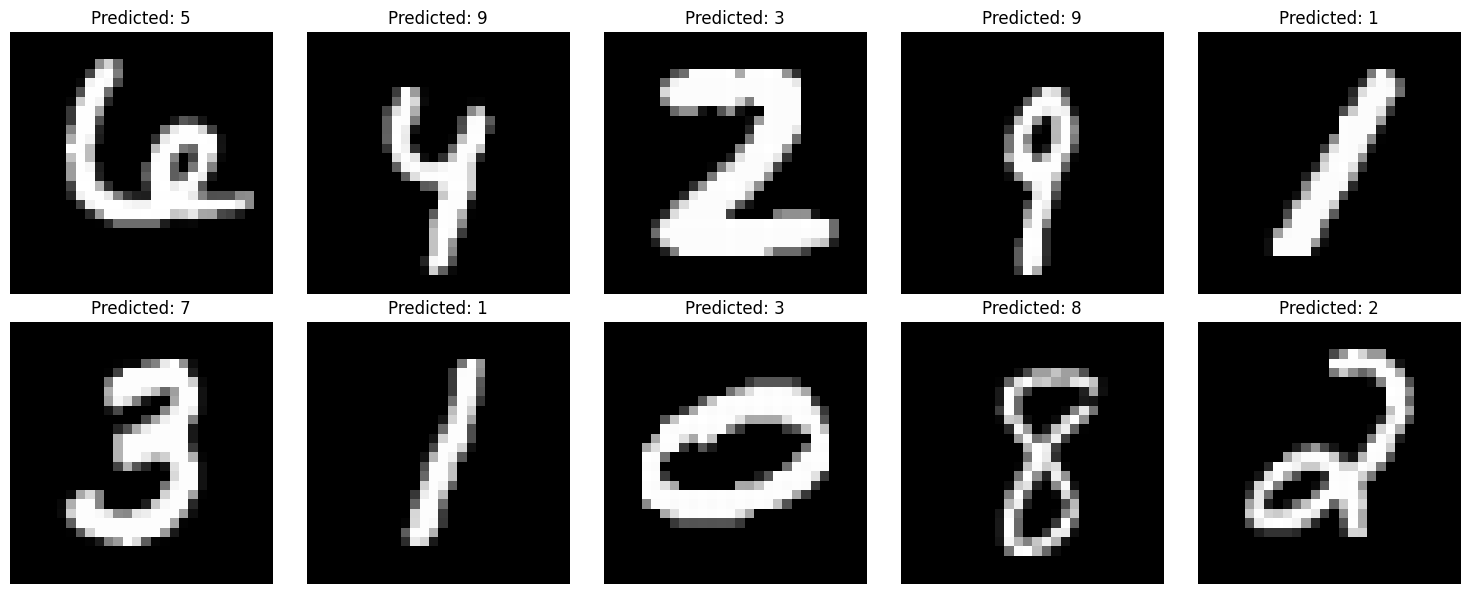

In [10]:
#one way of visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



def plot_qsvm_predictions(images, predictions, n=10):

    plt.figure(figsize=(15,6))
    
    for i in range(n):
        plt.subplot(2, 5, i + 1)

        
        if isinstance(images, pd.DataFrame):
            
            image = images.iloc[i].values.reshape(48,48)
        else:
           
            image = images[i].reshape(28, 28)

        
        plt.imshow(image, cmap='gray')
        plt.axis('off') 

       
        plt.title(f"Predicted: {predictions[i]}")

    plt.tight_layout()
    plt.show()


X_test_np = X_test.values if isinstance(X_test, pd.DataFrame) else X_test



plot_qsvm_predictions(X_test_np[:10], predictions[:10])
